# IBM Quantum Challenges 2021 Ex5




# TL;DR
For those who just want the solution, here are the settings 
* freezeCore = `True`
* orbital removal = `[3,4]`
* mapper = `ParityMapper`
* Ansatz model = `TwoLocal`
    * rotation_blocks = `['rz', 'ry']`
    * entanglement_blocks = `['cx']`
    * entanglement = `'linear'`
    * repetitions = `1`
    * skip_final_rotation_layer = `False`
* Z2 Symmetry reduction `[-1,-1]`
and here is the code that generate my final ANSATZ

{'pass': True, 'optimizer': 'SLSQP', 'mapping': 'ParityMapper', 'ansatz': 'TwoLocal', 'rotation blocks': ['rz', 'ry'], 'entanglement_blocks': ['cx'], 'entanglement': 'linear', 'repetitions': 1, 'skip_final_rotation_layer': False, 'energy (Ha)': -1.0863669545392787, 'error (mHa)': 2.339061195462566, '# of parameters': 16, 'final parameters': array([ 9.99385468e-03,  1.43052436e-01,  1.05677434e-05,  5.25668209e-02,
        3.13162460e+00,  3.19040582e+00,  4.44289254e-01,  9.99392720e-03,
        9.99862400e-03,  9.99797893e-03,  2.52351997e-01, -5.66652591e-03,
       -3.14157204e+00, -2.69653124e+00, -6.87127704e-02,  7.43661883e-02]), '# of evaluations': 905, 'optimizer time': 6.486678108994965, '# of qubits': 4, '# of CNOTs': 3, 'score': 3}


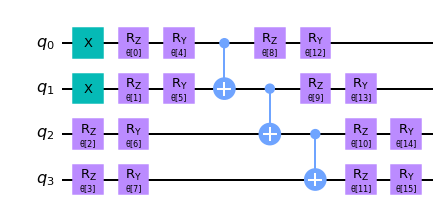

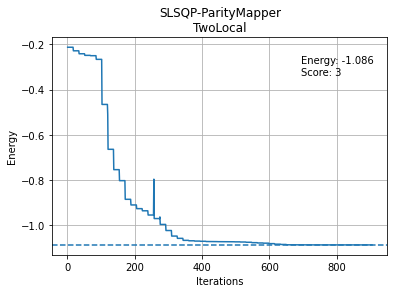

In [1]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms import VQE
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller 
import numpy as np 
from IPython.display import display, clear_output

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
freeze = True 
orbital_removal = [3,4]
two_qubit_reduction = True
z2symmetry_reduction = [-1,-1]    
backend = Aer.get_backend('statevector_simulator')
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

## create electronics structure problem
freezeT = FreezeCoreTransformer(freeze_core=freeze, remove_orbitals=orbital_removal)
problem = ElectronicStructureProblem(driver, q_molecule_transformers = [freezeT])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper = ParityMapper()

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

converter = QubitConverter(mapper=mapper, 
                           two_qubit_reduction=two_qubit_reduction, 
                           z2symmetry_reduction=z2symmetry_reduction)

qubit_op = converter.convert(main_op, num_particles=num_particles)

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

rotation_blocks = ['rz', 'ry']
entanglement_blocks = ['cx']
entanglement = 'linear'
repetitions = 1
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
ansatz.compose(init_state, front=True, inplace=True)

optimizer = SLSQP(maxiter=3000, ftol=1e-10, tol=1e-10) 

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
#print("Exact electronic energy", exact_energy)
#print(result_exact)

counts = []
values = []
params = []
deviation = []
# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std) 

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

## checking and printing information about the ANSATS and VQE result

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value


result_dict = {
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    'optimizer': optimizer.__class__.__name__,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')


print(result_dict)
ansatz.draw('mpl')


# What I went through during the Challenge, and some hint and tips




## 1. Exploring Qiskit 
### 1.1 Read through the background theory

The first thing I did was to explore the Hydrogen example given in the notebook. Personally, I am more of a Python programmer then a Quantum chemist. Hence, I find the python codes easier to understand then the technical blurb in the theory section. So, although I did read the theory section, I did not gain too much useful information on the first pass.


### 1.2 Exploring the code

#### 1.2.1 setting up LiH molecule

The first piece of the code is to specify the $H_2$ molecure and obtain the driver. From reading the code, the first thing I notice is that I need the `qmolecule` object returned from executing `driver.run()`

This is where being familier with Jupyter helps. In jupyter notebook, a very helpful command is the `?` and `??` applied to objects, function, or modules. This will popup a panel at the bottom of the notebook showing the docstring `?`, and the source code `??` from the code in the current system. 


Try `shift-Enter` in the following cell to see this feature in operation.

In [2]:
qmolecule?

Type:        QMolecule
String form: <qiskit_nature.drivers.qmolecule.QMolecule object at 0x7f3bf554b9a0>
File:        ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/drivers/qmolecule.py
Docstring:  
Molecule data class containing driver result.

When one of the chemistry :mod:`~qiskit_nature.drivers` is run and instance
of this class is returned. This contains various properties that are made available in
a consistent manner across the various drivers.

Note that values here, for the same input molecule to each driver, may be vary across
the drivers underlying code implementation. Also some drivers may not provide certain fields
such as dipole integrals in the case of :class:`~qiskit_nature.drivers.PyQuanteDriver`.

This class provides methods to save it and load it again from an HDF5 file


In [3]:
driver.run?

Signature: driver.run() -> qiskit_nature.drivers.qmolecule.QMolecule
Docstring:
Runs driver to produce a QMolecule output.

Returns:
    A QMolecule containing the molecular data.
File:      ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/drivers/pyscfd/pyscfdriver.py
Type:      method


In [4]:
PySCFDriver?

Init signature:
PySCFDriver(
    atom: Union[str, List[str]] = 'H 0.0 0.0 0.0; H 0.0 0.0 0.735',
    unit: qiskit_nature.drivers.units_type.UnitsType = <UnitsType.ANGSTROM: 'Angstrom'>,
    charge: int = 0,
    spin: int = 0,
    basis: str = 'sto3g',
    hf_method: qiskit_nature.drivers.fermionic_driver.HFMethodType = <HFMethodType.RHF: 'rhf'>,
    conv_tol: float = 1e-09,
    max_cycle: int = 50,
    init_guess: qiskit_nature.drivers.pyscfd.pyscfdriver.InitialGuess = <InitialGuess.MINAO: 'minao'>,
    max_memory: Optional[int] = None,
    molecule: Optional[qiskit_nature.drivers.molecule.Molecule] = None,
) -> None
Docstring:     
Qiskit chemistry driver using the PySCF library.

See https://sunqm.github.io/pyscf/
Init docstring:
Args:
    atom: Atom list or string separated by semicolons or line breaks. Each element in the
        list is an atom followed by position e.g. `H 0.0 0.0 0.5`. The preceding example
        shows the `XYZ` format for position but `Z-Matrix` format is supp

Now, we have obtained some information about the code:

fact:
1. `PySCDFDriver` have additional parameters that can be tuned. 
2. `qmolecule` contains properties of the molecule.

For tutorial question 1, I had a quick look at the qmolecule object with `??` and the information can be infered from reading the source code and comment of the __init__ function.

In [5]:
qmolecule??

Type:        QMolecule
String form: <qiskit_nature.drivers.qmolecule.QMolecule object at 0x7f3bf554b9a0>
File:        ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/drivers/qmolecule.py
Source:     
class QMolecule:
    """
    Molecule data class containing driver result.

    When one of the chemistry :mod:`~qiskit_nature.drivers` is run and instance
    of this class is returned. This contains various properties that are made available in
    a consistent manner across the various drivers.

    Note that values here, for the same input molecule to each driver, may be vary across
    the drivers underlying code implementation. Also some drivers may not provide certain fields
    such as dipole integrals in the case of :class:`~qiskit_nature.drivers.PyQuanteDriver`.

    This class provides methods to save it and load it again from an HDF5 file
    """

    QMOLECULE_VERSION = 3

    def __init__(self, filename=None):
        self._filename = filename

        

Note: From this point onwards, I am only going to point out the object that I have explored, and the facts I have obtained by source code diving without presenting the details. Just to make the descriptiuon short.

#### 1.2.2 Setting up the Electronic Structure 

Next, the functions to explore are the `ElectronicStructureProblem` and `second_q_ops`

In [6]:
ElectronicStructureProblem??

Init signature:
ElectronicStructureProblem(
    driver: qiskit_nature.drivers.fermionic_driver.FermionicDriver,
    q_molecule_transformers: Optional[List[qiskit_nature.transformers.base_transformer.BaseTransformer]] = None,
)
Source:        
class ElectronicStructureProblem(BaseProblem):
    """Electronic Structure Problem"""

    def __init__(self, driver: FermionicDriver,
                 q_molecule_transformers: Optional[List[BaseTransformer]] = None):
        """

        Args:
            driver: A fermionic driver encoding the molecule information.
            q_molecule_transformers: A list of transformations to be applied to the molecule.
        """
        super().__init__(driver, q_molecule_transformers)

    @property
    def num_particles(self) -> Tuple[int, int]:
        molecule_data_transformed = cast(QMolecule, self._molecule_data_transformed)
        return molecule_data_transformed.num_alpha, molecule_data_transformed.num_beta

    def second_q_ops(self) -> List[Sec

fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'

Now, we come to the qubit converter section. Which echos some of the confusing terminologies read in the theory section and I start to think that some of these will be important to solving the challenge. 

I take note that there are two important object introduced here, the mappers and converters. 

#### Assumption:
1. converter and mappers are important parameter to tune.

Firstly, lets check out the `ParityMapper`, and then the other two that are in the code but not used for Hydrogen.

In [7]:
ParityMapper?

Init signature: ParityMapper()
Docstring:      The Parity fermion-to-qubit mapping. 
Init docstring:
Args:
    allows_two_qubit_reduction: Set if mapper will create known symmetry such that the
    number of qubits in the mapped operator can be reduced accordingly.
File:           ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/mappers/second_quantization/parity_mapper.py
Type:           ABCMeta
Subclasses:     


In [8]:
JordanWignerMapper?

Init signature: JordanWignerMapper(allows_two_qubit_reduction: bool = False)
Docstring:      The Jordan-Wigner fermion-to-qubit mapping. 
Init docstring:
Args:
    allows_two_qubit_reduction: Set if mapper will create known symmetry such that the
    number of qubits in the mapped operator can be reduced accordingly.
File:           ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/mappers/second_quantization/jordan_wigner_mapper.py
Type:           ABCMeta
Subclasses:     


In [9]:
BravyiKitaevMapper?

Init signature: BravyiKitaevMapper(allows_two_qubit_reduction: bool = False)
Docstring:      The Bravyi-Kitaev fermion-to-qubit mapping. 
Init docstring:
Args:
    allows_two_qubit_reduction: Set if mapper will create known symmetry such that the
    number of qubits in the mapped operator can be reduced accordingly.
File:           ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/mappers/second_quantization/bravyi_kitaev_mapper.py
Type:           ABCMeta
Subclasses:     


When I go through the documentation, I took note that these all takes a parameter named `allows_two_qubit_reduction` and there are no much difference in the documentation other then the name.

Next, we take a look at the converter.

In [10]:
QubitConverter?

Init signature:
QubitConverter(
    mapper: qiskit_nature.mappers.second_quantization.qubit_mapper.QubitMapper,
    two_qubit_reduction: bool = False,
    z2symmetry_reduction: Union[str, List[int], NoneType] = None,
)
Docstring:     
A converter from Second-Quantized to Qubit Operators.

This converter can be configured with a mapper instance which will later be used
when 2nd quantized operators are requested to be converted (mapped) to qubit operators.

For a Fermionic system, when its a electronic problem, there are certain mappers, such as
the :class:`~qiskit_nature.mappers.second_quantization.ParityMapper` that introduces known
symmetries, by virtue of the mapping, that can be exploited to reduce the size of the
problem, i.e the qubit operator, by two qubits. The two qubit reduction setting indicates
to do this where possible - i.e. mapper supports it and the number of particles in the
Fermionic system is provided for the conversion. (The number of particles is used to
determine t

When I get to look into the document for the converter, I noted that there is another `two_qubit_reduction` parameter and another `z2symmetry_reduction`. which I happily added to my fact list. Note that there was an `allow_two_qubit_reduction` flag in the Mapper.

fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'
5. `Mapper` looks very similar to each other but only ParityMapper have `allow_two_qubit_reduction = True`
6. `QubitConverter` takes another parameter named `two_qubit_reduction`
7. `QubitConverter` has a parameter named `z2symmetry_reduction`

I was a bit confused about the two_qubit_reduction flag appearing in two places. With a bit of code diving, I made the following assumption:

    two_qubit_reduction is a technique for reduce the ansatz size, but it is only allowed with the ParityMapper, hence only ParityMapper set it to true in the __init__ function of the parent class FermionicOperator. And, the process of removing the two qubits are done in the subsequent converter.

#### 1.2.3 HartreeFock 

Next, I did the same with `HartreeFock` function and also note that how the property of the molecule are used to provide the parameters for some of these function. This is just for setting up the initial conditions and lt appear to be a parameter not to be changed by looking ahead into the problem statement.

In [11]:
HartreeFock?

Init signature:
HartreeFock(
    num_spin_orbitals: int,
    num_particles: Tuple[int, int],
    qubit_converter: qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter,
) -> None
Docstring:      A Hartree-Fock initial state.
Init docstring:
Args:
    num_spin_orbitals: The number of spin orbitals, has a min. value of 1.
    num_particles: The number of particles as a tuple storing the number of alpha- and
                   beta-spin electrons in the first and second number, respectively.
    qubit_converter: a QubitConverter instance.
File:           ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/circuit/library/initial_states/hartree_fock.py
Type:           type
Subclasses:     


#### 1.2.4 ANSATZ
When I read this part of the code, I immediately assumed that this is the place where all the tuning parameters are. (hindsight: Mapper and converter is where all the tuning happens initially) In summary, these are the additional information obtained.

fact:
fact:
1. `PySCDFDriver` have additional parameters that can be tuned.
2. `qmolecule` contains properties of the molecule.
3. `ElectronicsStructureProblem` takes a second parameter of the class `qiskit_nature.transformers.base_transformer.BaseTransformer`
4. `second_q_ops` returns a list and it appears that the code only interested in the first element. (from the comment in the source code, the first in the list is something called 'electronic operator'
5. `Mapper` looks very similar to each other but only ParityMapper have `allow_two_qubit_reduction = True`
6. `QubitConverter` takes another parameter named `two_qubit_reduction`
7. `QubitConverter` has a parameter named `z2symmetry_reduction`
8. TwoLocal have a lot of parameters with many combinations. Remember to look at the document later.
9. UCCSD, SUCCD, PUCCD are all related, but they have a lot less parameter to tune.

In [12]:
TwoLocal?

Init signature:
TwoLocal(
    num_qubits: Optional[int] = None,
    rotation_blocks: Union[str, List[str], type, List[type], qiskit.circuit.quantumcircuit.QuantumCircuit, List[qiskit.circuit.quantumcircuit.QuantumCircuit], NoneType] = None,
    entanglement_blocks: Union[str, List[str], type, List[type], qiskit.circuit.quantumcircuit.QuantumCircuit, List[qiskit.circuit.quantumcircuit.QuantumCircuit], NoneType] = None,
    entanglement: Union[str, List[List[int]], Callable[[int], List[int]]] = 'full',
    reps: int = 3,
    skip_unentangled_qubits: bool = False,
    skip_final_rotation_layer: bool = False,
    parameter_prefix: str = 'θ',
    insert_barriers: bool = False,
    initial_state: Optional[Any] = None,
) -> None
Docstring:     
The two-local circuit.

The two-local circuit is a parameterized circuit consisting of alternating rotation layers and
entanglement layers. The rotation layers are single qubit gates applied on all qubits.
The entanglement layer uses two-qubit gates to

In [13]:
UCCSD?

Init signature:
UCCSD(
    qubit_converter: Optional[qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter] = None,
    num_particles: Optional[Tuple[int, int]] = None,
    num_spin_orbitals: Optional[int] = None,
    reps: int = 1,
    initial_state: Optional[qiskit.circuit.quantumcircuit.QuantumCircuit] = None,
)
Docstring:     
The UCCSD Ansatz.

This is a convenience subclass of the UCC Ansatz. For more information refer to :class:`UCC`.
Init docstring:
Args:
    qubit_converter: the QubitConverter instance which takes care of mapping a
        :class:`~.SecondQuantizedOp` to a :class:`PauliSumOp` as well as performing all
        configured symmetry reductions on it.
    num_particles: the tuple of the number of alpha- and beta-spin particles.
    num_spin_orbitals: the number of spin orbitals.
    reps: The number of times to repeat the evolved operators.
    initial_state: A `QuantumCircuit` object to prepend to the circuit.
File:           ~/apps/anaconda3

In [14]:
SUCCD?

Init signature:
SUCCD(
    qubit_converter: Optional[qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter] = None,
    num_particles: Optional[Tuple[int, int]] = None,
    num_spin_orbitals: Optional[int] = None,
    reps: int = 1,
    initial_state: Optional[qiskit.circuit.quantumcircuit.QuantumCircuit] = None,
    include_singles: Tuple[bool, bool] = (False, False),
)
Docstring:     
The SUCCD Ansatz.

The SUCCD Ansatz (by default) only contains double excitations. Furthermore, it only considers
the set of excitations which is symmetrically invariant with respect to spin-flips of both
particles. For more information see also [1].

Note, that this Ansatz can only work for singlet-spin systems. Therefore, the number of alpha
and beta electrons must be equal.

This is a convenience subclass of the UCC Ansatz. For more information refer to :class:`UCC`.

References:

    [1] https://arxiv.org/abs/1911.10864
Init docstring:
Args:
    qubit_converter: the QubitConver

In [15]:
PUCCD?

Init signature:
PUCCD(
    qubit_converter: Optional[qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter] = None,
    num_particles: Optional[Tuple[int, int]] = None,
    num_spin_orbitals: Optional[int] = None,
    reps: int = 1,
    initial_state: Optional[qiskit.circuit.quantumcircuit.QuantumCircuit] = None,
    include_singles: Tuple[bool, bool] = (False, False),
)
Docstring:     
The PUCCD Ansatz.

The PUCCD Ansatz (by default) only contains double excitations. Furthermore, it enforces all
excitations to occur in parallel in the alpha and beta species. For more information see also
[1].

Note, that this Ansatz can only work for singlet-spin systems. Therefore, the number of alpha
and beta electrons must be equal.

This is a convenience subclass of the UCC Ansatz. For more information refer to :class:`UCC`.

References:

    [1] https://arxiv.org/abs/1911.10864
Init docstring:
Args:
    qubit_converter: the QubitConverter instance which takes care of mapping

I also noted that the UCCSD, SUCCD. PUCCD are all subclass of `UCC`. To me, all of these acronymes do not mean much, but from experience with python, I know that there may be parameters hidden in the parent class. So, I want to find `UCC` and see what I can find. 

In [16]:
from qiskit_nature.circuit.library import UCC

In [17]:
UCC?

Init signature:
UCC(
    qubit_converter: Optional[qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter] = None,
    num_particles: Optional[Tuple[int, int]] = None,
    num_spin_orbitals: Optional[int] = None,
    excitations: Union[str, int, List[int], Callable[[int, Tuple[int, int]], List[Tuple[Tuple[int, ...], Tuple[int, ...]]]], NoneType] = None,
    alpha_spin: bool = True,
    beta_spin: bool = True,
    max_spin_excitation: Optional[int] = None,
    reps: int = 1,
    initial_state: Optional[qiskit.circuit.quantumcircuit.QuantumCircuit] = None,
)
Docstring:     
The Unitary Coupled-Cluster Ansatz. For more information, see [1].

This Ansatz is an :class:`~.EvolvedOperatorAnsatz` given by :math:`e^{T - T^{\dagger}}` where
:math:`T` is the *cluster operator*. This cluster operator generally consists of excitations
operators which are generated by :meth:`~.generate_fermionic_excitations`. You can also use a
custom excitation generator method by passing a cal

Read the documentation of UCC and I amd thinking to myself, jackpot. The plan of attack start to become clear. 
1. create the equivelent code for the LiH molecule. 
2. investigate the set of parameters found hidden in UCC, and start to optimise.

<font color='red'>I did not need to explore these parameters at the end. But knowing what's avaliable for tuning is always good.</font> 

#### 1.2.5 the optimisation algorithm

By now, I have spend several hours exploring the code, and finally got to some more familiar terrotory. The four optimizers. Firstly, my attention was drawn to the comment that I might need to change the parameters. BUT, from my experience, these are local optimisers, and there is not much tuning one can do except to reduce the tolerence, or the maximum evaluation or iterations.

Looking into the code, they don't look special and probably comes from the scipy package.

Instead of the default `COBLA`, I switched it to `SLSQP` mostly out of personal familiarity with that algorithm.

In [18]:
# check out the document of the different optimisation algoriths if you need to
#COBYLA?
SLSQP?

Init signature:
SLSQP(
    maxiter: int = 100,
    disp: bool = False,
    ftol: float = 1e-06,
    tol: Optional[float] = None,
    eps: float = 1.4901161193847656e-08,
) -> None
Docstring:     
Sequential Least SQuares Programming optimizer.

SLSQP minimizes a function of several variables with any combination of bounds, equality
and inequality constraints. The method wraps the SLSQP Optimization subroutine originally
implemented by Dieter Kraft.

SLSQP is ideal for mathematical problems for which the objective function and the constraints
are twice continuously differentiable. Note that the wrapper handles infinite values in bounds
by converting them into large floating values.

Uses scipy.optimize.minimize SLSQP.
For further detail, please refer to
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Init docstring:
Args:
    maxiter: Maximum number of iterations.
    disp: Set to True to print convergence messages.
    ftol: Precision goal for the 

#### 1.2.6 Result Checker

Next, we were introduced with another new function `GroundStateEigensolver`. From the documentation, it takes the converter as input, and what appears to be a generic Eigen Solver. 

In [19]:
GroundStateEigensolver??

Init signature:
GroundStateEigensolver(
    qubit_converter: qiskit_nature.converters.second_quantization.qubit_converter.QubitConverter,
    solver: Union[qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver.MinimumEigensolver, qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories.minimum_eigensolver_factory.MinimumEigensolverFactory],
) -> None
Source:        
class GroundStateEigensolver(GroundStateSolver):
    """Ground state computation using a minimum eigensolver."""

    def __init__(self, qubit_converter: QubitConverter,
                 solver: Union[MinimumEigensolver, MinimumEigensolverFactory]) -> None:
        """

        Args:
            qubit_converter: a class that converts second quantized operator to qubit operator
                             according to a mapper it is initialized with.
            solver: Minimum Eigensolver or MESFactory object, e.g. the VQEUCCSDFactory.
        """
        super().__init__(qubit_converter)
        

In [20]:
solver = NumPyMinimumEigensolverFactory()
solver?

Type:           NumPyMinimumEigensolverFactory
String form:    <qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory.NumPyMinimumEigensolverFactory object at 0x7f3bc367be20>
File:           ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/algorithms/ground_state_solvers/minimum_eigensolver_factories/numpy_minimum_eigensolver_factory.py
Docstring:      A factory to construct a NumPyMinimumEigensolver.
Init docstring:
Args:
    filter_criterion: callable that allows to filter eigenvalues/eigenstates. The minimum
        eigensolver is only searching over feasible states and returns an eigenstate that
        has the smallest eigenvalue among feasible states. The callable has the signature
        `filter(eigenstate, eigenvalue, aux_values)` and must return a boolean to indicate
        whether to consider this value or not. If there is no
        feasible element, the result can even be empty.
    use_default_

Note: usually, sufficient information can be obtained by appending `?` to the end of a function. In the above case, when the function returns a python object, it is more infromative to realise the object and perform the `?` on the object itself to get the information.

Finally, we got to the section of code that execute the `VQE`, and the required argument list do not contain anything that looks like a tuning parameter.

In [21]:
VQE?

Init signature:
VQE(
    ansatz: Optional[qiskit.circuit.quantumcircuit.QuantumCircuit] = None,
    optimizer: Optional[qiskit.algorithms.optimizers.optimizer.Optimizer] = None,
    initial_point: Optional[numpy.ndarray] = None,
    gradient: Union[qiskit.opflow.gradients.gradient_base.GradientBase, Callable, NoneType] = None,
    expectation: Optional[qiskit.opflow.expectations.expectation_base.ExpectationBase] = None,
    include_custom: bool = False,
    max_evals_grouped: int = 1,
    callback: Optional[Callable[[int, numpy.ndarray, float, float], NoneType]] = None,
    quantum_instance: Union[qiskit.providers.backend.Backend, qiskit.providers.basebackend.BaseBackend, qiskit.utils.quantum_instance.QuantumInstance, NoneType] = None,
) -> None
Docstring:     
The Variational Quantum Eigensolver algorithm.

`VQE <https://arxiv.org/abs/1304.3061>`__ is a quantum algorithm that uses a
variational technique to find
the minimum eigenvalue of the Hamiltonian :math:`H` of a given system.

A

Tutorial Question Two asked us to explore all the tunerable parameters and provide the ansatz. Which I skipped.

## Final Challenge

### Review known information

Combining the fact list obtained above and compare with the checklist we note that there is a hind on the parameters that wee need to tune. That will give us a good starting point to produce an acceptable result and then we can work on beating the best score.

So, here are the important bits. 
1. we need to find the freezeCore Transformer from qiskit_nature.transformers and combine with the finding of fact 3, we can workout how we should use the FreezeCore Transformers.
2. use ParityMapper with two_qubit_reduction=True to eliminate 2 qubits. - looks like we just need to set the flag to true. 
3. use z2Symmetry to reduce the qubits - which we know it is in QubitConverter


In [22]:
from qiskit_nature import transformers
transformers?

Type:        module
String form: <module 'qiskit_nature.transformers' from '/home/kuos/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/transformers/__init__.py'>
File:        ~/apps/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/transformers/__init__.py
Docstring:  
QMolecule Transformers (:mod:`qiskit_nature.transformers`)

.. currentmodule:: qiskit_nature.transformers

Transformers act on a :class:`~qiskit_nature.drivers.QMolecule` to produce an altered copy of it
as per the specific transformer. So for instance the :class:`FreezeCoreTransformer` will alter the
integrals and number of particles in a way that freezes the core orbitals, storing an extracted
energy in the QMolecule to compensate for this that would need to be included back into any ground
state energy computation to get complete result.

.. autosummary::
   :toctree: ../stubs/

   BaseTransformer
   ActiveSpaceTransformer
   FreezeCoreTransformer


Also, it appears that there is another transformer that we can use to further reduce the qubits. (Again, did not need to use this)

In [23]:
transformers.ActiveSpaceTransformer?

Init signature:
transformers.ActiveSpaceTransformer(
    num_electrons: Union[int, Tuple[int, int], NoneType] = None,
    num_molecular_orbitals: Optional[int] = None,
    active_orbitals: Optional[List[int]] = None,
)
Docstring:     
The Active-Space reduction.

The reduction is done by computing the inactive Fock operator which is defined as
:math:`F^I_{pq} = h_{pq} + \sum_i 2 g_{iipq} - g_{iqpi}` and the inactive energy which is
given by :math:`E^I = \sum_j h_{jj} + F ^I_{jj}`, where :math:`i` and :math:`j` iterate over
the inactive orbitals.
By using the inactive Fock operator in place of the one-electron integrals, `h1`, the
description of the active space contains an effective potential generated by the inactive
electrons. Therefore, this method permits the exclusion of non-core electrons while
retaining a high-quality description of the system.

For more details on the computation of the inactive Fock operator refer to
https://arxiv.org/abs/2009.01872.

The active space can be c

## Approach

I pull the code into a function that allows me to quickly explore the various parameters and proceed to find a good enough solution. The function I used is defined in the next cell. 

The defaults in the function are what I considered to be a very conservative starting point, applying only the reductions I am sure to work. And, I set the optimiser to have a very tight tolerence and long maxiter so that I will have a high change of finding a solution dispite a big and long running simulation.

In [24]:
def run(freeze = True, 
        orbital_removal = None, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        rotation_blocks = ['rz', 'ry'],
        entanglement_blocks = ['cx'],
        entanglement = 'full',
        optimizer_type = 'SLSQP',
        p_rep = 4,
        two_qubit_reduction = True,
        z2symmetry_reduction = None,  
        skip_final_rotation_layer = False,
        show_plot = True, save_plot=False):

    molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'

    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()

    ## create electronics structure problem
    freezeT = FreezeCoreTransformer(freeze_core=True, remove_orbitals=orbital_removal)
    if freeze == True:
        problem = ElectronicStructureProblem(driver, q_molecule_transformers = [freezeT])
    else:
        problem = ElectronicStructureProblem(driver)

    # Generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # Hamiltonian
    main_op = second_q_ops[0]

    # Setup the mapper and qubit converter


    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':  ## this gives a good starting point
        mapper = BravyiKitaevMapper()

    # The fermionic operators are mapped to qubit operators
    num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
    num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

    converter = QubitConverter(mapper=mapper, 
                               two_qubit_reduction=two_qubit_reduction, 
                               z2symmetry_reduction=z2symmetry_reduction)

    qubit_op = converter.convert(main_op, num_particles=num_particles)

    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)


    # print('init_state', init_state)

    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['rz', 'ry']
        # Entangling gates
        entanglement_blocks = ['cx']
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = p_rep

        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)


    # You may want to tune the parameters 
    # of each optimizer, here the defaults are used
    if optimizer_type == 'COBYLA':
        optimizer = COBYLA(maxiter=3000)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun=500)
    elif optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=500)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=3000, ftol=1e-10, tol=1e-10) 

    # result_exact = exact_diagonalizer(problem, converter)
    exact_energy = -1.089
    #print("Exact electronic energy", exact_energy)
    #print(result_exact)

    counts = []
    values = []
    params = []
    deviation = []
    # Print and save the data in lists
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std) 

    # Set initial parameters of the ansatz
    # We choose a fixed small displacement 
    # So all participants start from similar starting point
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    quantum_instance=backend,
                    callback=callback,
                    initial_point=initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)

    # Unroller transpile your circuit into CNOTs and U gates
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    score = cnots

    accuracy_threshold = 4.0 # in mHa
    energy = result.optimal_value

    if ansatz_type == "TwoLocal":
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': rotation_blocks,
            'entanglement_blocks': entanglement_blocks,
            'entanglement': entanglement,
            'repetitions': repetitions,
            'skip_final_rotation_layer': skip_final_rotation_layer,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    else:
        result_dict = {
            'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
            'optimizer': optimizer.__class__.__name__,
            'mapping': converter.mapper.__class__.__name__,
            'ansatz': ansatz.__class__.__name__,
            'rotation blocks': None,
            'entanglement_blocks': None,
            'entanglement': None,
            'repetitions': None,
            'skip_final_rotation_layer': None,
            'energy (Ha)': energy,
            'error (mHa)': (energy-exact_energy)*1000,
            '# of parameters': len(result.optimal_point),
            'final parameters': result.optimal_point,
            '# of evaluations': result.optimizer_evals,
            'optimizer time': result.optimizer_time,
            '# of qubits': int(qubit_op.num_qubits),
            '# of CNOTs': cnots,
            'score': score}
    if show_plot:
        # Plot the results
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 1)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Energy')
        ax.grid()
        fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
        plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
        ax.plot(counts, values)
        ax.axhline(exact_energy, linestyle='--')
    if save_plot:    
        fig_title = f"\
        {result_dict['optimizer']}-\
        {result_dict['mapping']}-\
        {result_dict['ansatz']}-\
        Energy({result_dict['energy (Ha)']:.3f})-\
        Score({result_dict['score']:.0f})\
        .png"
        fig.savefig(fig_title, dpi=300)

    return(result_dict, ansatz)
    

we start with `freezeCore`, `two_qubit_reduction` and orbital_removal = `[3,4]`. These values/setting are recommended in previous reference materials. For the other parameters I set them to what I think are safe values.

pass: False ;  error (mHa) 18.399722845240383


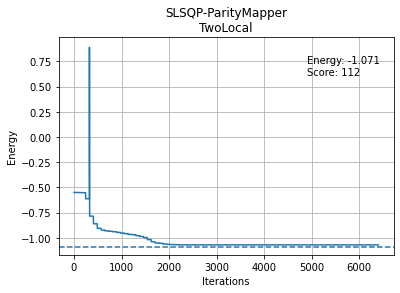

In [25]:
[r,a] = run()
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])


Noting that the final energy error is close but not good enough, I start to explore different ansatz type thinking that it will improve things. And ... indeed we got a pass. 

In [26]:
print('CNOTS:', r['score'])

CNOTS: 112


pass: True ;  error (mHa) -0.7823963464594907
CNOTS: 1276


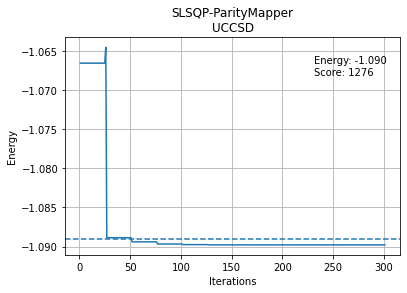

In [27]:
[r,a] = run(ansatz_type = 'UCCSD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

And look at the energy error! But the number of CNOT is not acceptable. But progress.

Remember that we have two other variants of ansats to try, and also noting that the optimizer seems to be working better with these.

pass: True ;  error (mHa) 1.4153880269276442
CNOTS: 760


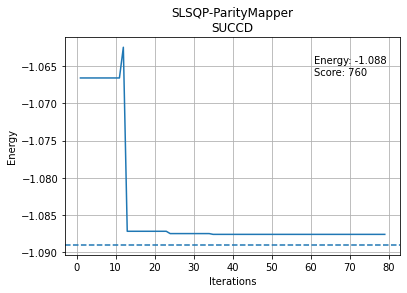

In [28]:
[r,a] = run(ansatz_type = 'SUCCD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

Now, we are looking better.

pass: True ;  error (mHa) 3.2658883714065112
CNOTS: 304


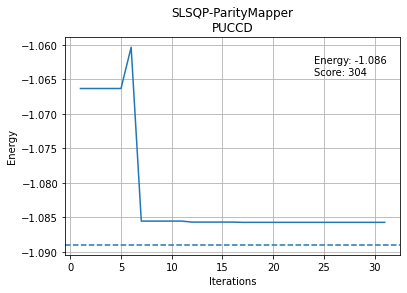

In [29]:
[r,a] = run(ansatz_type = 'PUCCD')
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

And we are just a bit off the acceptable energy here. But noting that PUCCD has the smallest number of qubuts.

#### z2Symmetry

Recalling the documentation from z2Symmetry from `QubitConverter` that it can be 'auto' or a list of 1 or -1. The obvious thing is to try 'auto' but we get an error message. next, I tries a list with 1 element, 2, etc and find that it appear to be doing something with 2 elements. no more no less. 

Staying with 'SUCCD' ansats, I then tries `[1,1]`, `[1,-1]`, `[-1,-1]`, `[-1,1]`

There is little logic here, just bruteforcing. And the best solution 1s `[1,1]`



pass: True ;  error (mHa) 1.4153880361931215
CNOTS: 334


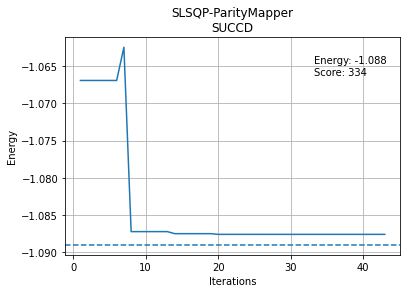

In [30]:
[r,a] = run(ansatz_type = 'SUCCD', z2symmetry_reduction = [1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

This gives me the first submittable answer. and I take note of the acceptable energy as well as I have found that it is possible to have the answer rejected by the grader that shows a pass in the result when the exact energy calculation are off. I did not bother to remove the exact eigen solver and hardcode the acceptence criteria, but that can be easily done. I simply take note when the energy was off.

Now, the next step is somple. Remember that 'PUCCD' got close last time, lets try our luck there.

pass: True ;  error (mHa) 3.2658883714085096
CNOTS: 254


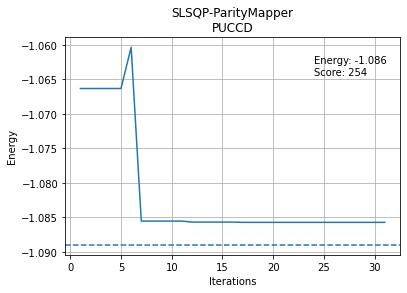

In [31]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

Now, noting that this gives the same error as without z2symmetry_reduction, I tries the other three settings [0,-1], ... etc just to make sure. By now, I also noticed the optimisaer can find the solution really quick. Probably because of the z2symmetry.

pass: False ;  error (mHa) 487.6087956454795
CNOTS: 254


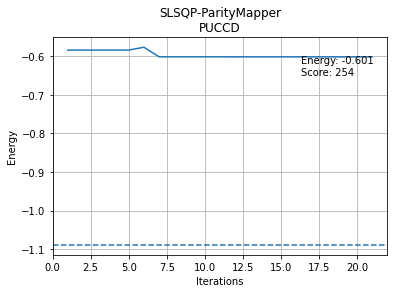

In [32]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [-1,-1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

pass: False ;  error (mHa) 594.5045264682252
CNOTS: 182


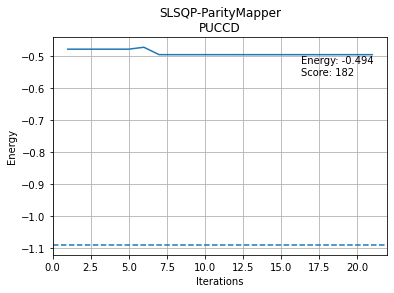

In [33]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [1,-1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

pass: False ;  error (mHa) 487.6087956454604
CNOTS: 254


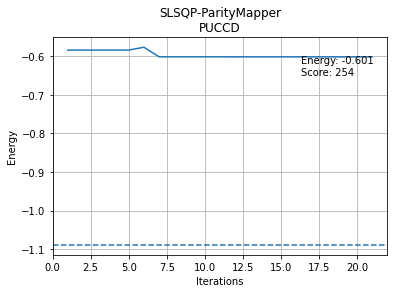

In [34]:
[r,a] = run(ansatz_type = 'PUCCD', z2symmetry_reduction = [-1,1])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

with the above three fails, I am somewhat convinced that z2Symmetry has to be [1,1] as all other setting are just way off.

Also, note that we are down to 6 qubits, and we still have not used orbital removal. 

So now, is the time to remove orbits. With a list specifying which orbit to remove. 

Firstly, how many orbits did we have? didn't we see a question that ask us about finding the property of the molecules? 

This was my answer to the first tutorial question but applied to the LiH molecure.

In [35]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy
print(n_el, n_mo, n_so, n_q, e_nn)

4 6 12 12 1.0259348796432726


so, 6 orbits, and let me try removing the last one. Perhaps there is some logic in the ordering... and note the intentional error.

In [36]:
[r,a] = run(ansatz_type = 'SUCCD', z2symmetry_reduction = [-1,-1], orbital_removal = [6])
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
print('CNOTS:', r['score'])

IndexError: index 6 is out of bounds for axis 0 with size 6

now, 6 orbits, indexed 0..5, and the error message confirmed it. so, how many combination? Well, there is a better way.

Lets do 6 experiments, removing one of the six and see which does not break the system.

In [37]:
for i in range(6):
    try:
        [r,a] = run(ansatz_type = 'UCCSD', z2symmetry_reduction = [-1,-1], orbital_removal = [i], show_plot = False, save_plot=False)
        print(i, '  pass:',r['pass'], ';  error (mHa)', r['error (mHa)'], '; energy', 'energy (Ha)')
    except:
        print(i, '  exception')

2   pass: False ;  error (mHa) 188.16685303981652 ; energy energy (Ha)
3   exception
4   exception
5   exception


And we found that we can only remove orbit 2 and the solution does not pass the test.

In [38]:
[r,a] = run(ansatz_type = 'UCCSD', z2symmetry_reduction = [-1,-1], orbital_removal = [2], show_plot = False, save_plot=False)

'Evaluation: 24, Energy: -0.9008331469602671, Std: 0.0'

and the energy just do not look correct.

By now, I have getting close to the end of exploring the UCC family of ansats. and still have not found a working orbit removal. So, time to explore the TwoLocal but with the additional optimisation we have found when exploring the UCC families.

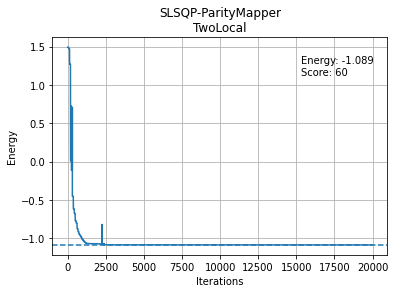

In [39]:
[r,a] = run(freeze = True, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'full',
        p_rep=4,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)

In [40]:
r

{'pass': True,
 'optimizer': 'SLSQP',
 'mapping': 'ParityMapper',
 'ansatz': 'TwoLocal',
 'rotation blocks': ['rz', 'ry'],
 'entanglement_blocks': ['cx'],
 'entanglement': 'full',
 'repetitions': 4,
 'skip_final_rotation_layer': False,
 'energy (Ha)': -1.0892381212457753,
 'error (mHa)': -0.23812124577538007,
 '# of parameters': 60,
 'final parameters': array([ 9.87417975e-03, -2.11244925e-01, -7.57314155e-02,  8.39746402e-03,
        -4.74779310e-04, -3.18291623e-05,  2.09755782e-06,  2.06535882e-06,
        -6.39371451e-06, -1.33102011e-02, -5.08981859e-04,  1.00079357e-02,
        -1.36832450e-03,  4.58372295e+00,  4.89634935e-02,  6.91198146e-02,
        -1.57361426e-02, -5.26138792e-04,  3.21299196e-05, -3.09995368e-07,
         6.35239474e-08, -1.92456766e-06,  1.00515578e-02,  1.61496855e+00,
         1.08558904e+00, -2.55807944e-01, -4.38295564e-03,  2.50060942e-01,
        -6.93795371e-03, -1.65932099e-02,  2.42610265e-04,  2.04466713e-06,
        -7.33585402e-06,  9.90504789e

Now, progress. The first thing I did was to submit this 60 CNOT Solution before I proceed.

The next obvious parameter to to use 'linear' entanglement because from its name, it will get us the best reduction in the number of CNOTS. And it is much easier then figuring out removing orbits.

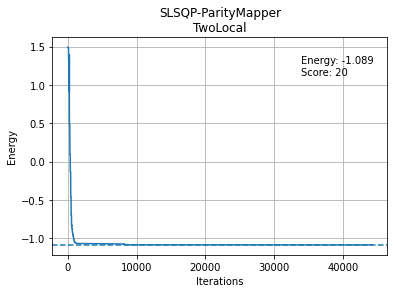

In [41]:
[r,a] = run(freeze = True, 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep=4,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)

In [42]:
r

{'pass': True,
 'optimizer': 'SLSQP',
 'mapping': 'ParityMapper',
 'ansatz': 'TwoLocal',
 'rotation blocks': ['rz', 'ry'],
 'entanglement_blocks': ['cx'],
 'entanglement': 'linear',
 'repetitions': 4,
 'skip_final_rotation_layer': False,
 'energy (Ha)': -1.0891248292016003,
 'error (mHa)': -0.12482920160028499,
 '# of parameters': 60,
 'final parameters': array([ 8.07543209e-03, -1.56405932e+00, -1.57075010e+00,  9.62235425e-01,
        -2.81667192e+00,  3.00875785e+00, -3.48073463e-04, -2.33215964e-03,
        -5.34611292e-06,  1.13268897e+00, -1.93538383e+00,  7.95993093e-03,
        -2.88681637e-01, -2.46250360e-02, -2.94554064e-01, -7.31526793e-05,
         5.48419155e-01,  7.85273939e-03,  2.06486081e-03,  2.81161832e-03,
        -5.54351393e-04, -5.19908852e-06,  9.76858913e-03, -2.05804247e-01,
         1.35490562e-01,  1.71735110e+00,  1.62069354e-01,  2.81414641e-02,
        -2.56275504e-04, -1.08088703e+00,  6.82136835e-02,  1.13729690e-01,
        -2.32915523e-03,  9.6172719

Next, I reduce the repeats and note that it gives acceptable answer at repeat 3

In [43]:
msg = ''
for repeat in [3,2,1]:
    [r,a] = run(freeze = True, 
            mapper_type = "ParityMapper", 
            ansatz_type = 'TwoLocal', 
            entanglement = 'linear',
            p_rep=repeat,
            two_qubit_reduction = True,
            z2symmetry_reduction = [1,1],  
            show_plot = False, 
            save_plot=False)
    msg = msg + "%d pass: %s\n"%(repeat, r['pass'])
    
print(msg)

3 pass: True
2 pass: True
1 pass: False



Finally, I tackle the orbital_removal again, but this time, using the TwoLocal Ansatz. Note that while I am experimenting with the orbital reduction, z2symmetry produce an error message on the size, so I simply modify it to just 1 element.

In [49]:
msg = ''
for o in [0,1,2,3,4,5]:
    try:
        [r,a] = run(freeze = True, 
                orbital_removal = [o],
                mapper_type = "ParityMapper", 
                ansatz_type = 'TwoLocal', 
                entanglement = 'linear',
                p_rep=2,
                two_qubit_reduction = True,
                z2symmetry_reduction = [1,1],  
                show_plot = False, 
                save_plot=False)
        msg += '%d pass: %s\n'%(o, r['pass'])
    except:
        msg += '%d exception\n'%o
print(msg)                              


0 pass: False
1 pass: False
2 pass: True
3 exception
4 exception
5 exception



pass: True ;  error (mHa) 3.9719155851598575


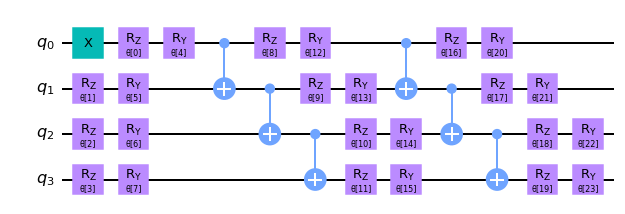

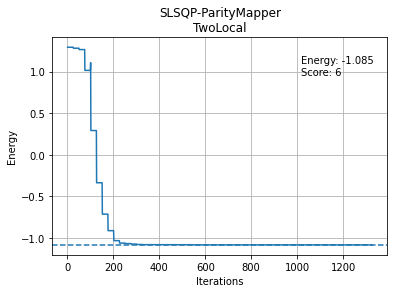

In [55]:
[r,a] = run(freeze = True, 
        orbital_removal = [2], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 2,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

pass: False ;  error (mHa) 4.01024287578533


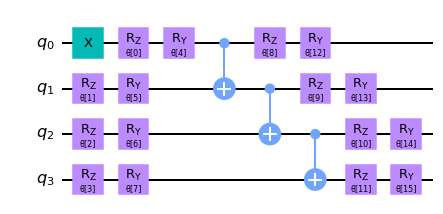

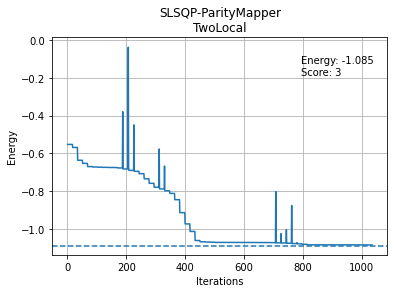

In [56]:
[r,a] = run(freeze = True, 
        orbital_removal = [2], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

In [57]:
[r,a] = run(freeze = True, 
        orbital_removal = [3], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

QiskitNatureError: 'z2symmetry_reduction tapering values list has invalid length 2 should be 1'

Now, nothing looks right and I start to retrack my steps and see if I missed a turn somewhere. After looking into previous examples, I found that there are two orbits that can be removed, and also, while exploring the error messages, I am guessing that orbit 0, and 1 should be kept or else the initial setup gets messed up. 

So, since there are plenty of time left in the challenge, I will just brute force the orbit reduction pairs.

In [52]:
msg = ''
for o in [[2,3],[2,4],[2,5],[3,3],[3,4],[3,5],[4,5]]:
    try:
        [r,a] = run(freeze = True, 
                orbital_removal = o,
                mapper_type = "ParityMapper", 
                ansatz_type = 'TwoLocal', 
                entanglement = 'linear',
                p_rep=2,
                two_qubit_reduction = True,
                z2symmetry_reduction = [1,1],  
                show_plot = False, 
                save_plot=False)
        msg += '[%d,%d] pass: %s\n'%(o[0], o[1], r['pass'])
    except:
        msg += '[%d,%d] exception\n'%(o[0], o[1])
print(msg)   

[2,3] exception
[2,4] exception
[2,5] exception
[3,3] exception
[3,4] pass: True
[3,5] exception
[4,5] exception



now, look at this! [3,4] lets see what it gives us.

pass: True ;  error (mHa) 0.309432362493256


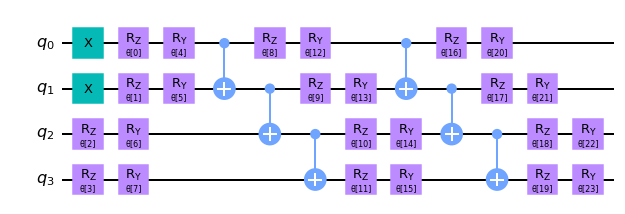

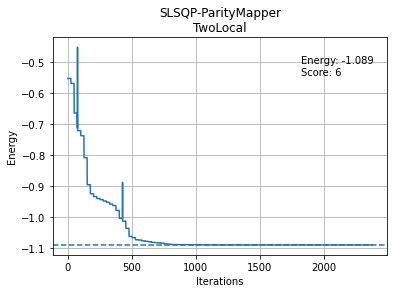

In [58]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 2,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

6 CNOTS. And let me remove another repeat to see if it still works.

In [ ]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')

'Evaluation: 895, Energy: -1.086366954546917, Std: 0.0'

once we see that orbit 3, and 4 can be removed, we attempt to further reduce the repeats and get our final solution

pass: True ;  error (mHa) 2.633045456425176


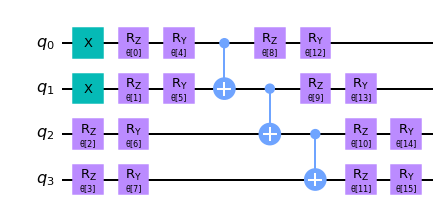

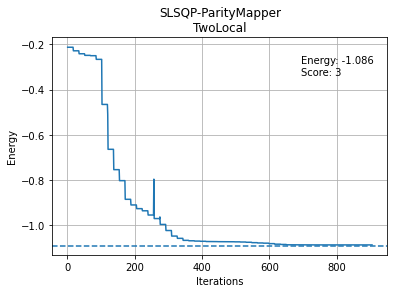

In [48]:
[r,a] = run(freeze = True, 
        orbital_removal = [3,4], 
        mapper_type = "ParityMapper", 
        ansatz_type = 'TwoLocal', 
        entanglement = 'linear',
        p_rep = 1,
        two_qubit_reduction = True,
        z2symmetry_reduction = [1,1],  
        show_plot = True, 
        save_plot=False)
print('pass:',r['pass'], ';  error (mHa)', r['error (mHa)'])
a.draw('mpl')